In [1]:
# from google.colab import drive
# drive.mount('/content/drive/')

## **학습 & 테스트 프로세스 요약**
| 단계 | 학습 (Train) | 테스트 (Test) |
|------|------------|-------------|
| **1. 데이터 입력** | CSV 파일 (이미 추출된 특징값) | 동영상 |
| **2. 특징 추출** | CSV에서 불러오기 | 동영상 → 프레임 추출 → 12개 묶음 → 특징 추출 |
| **3. 데이터 변환** | `(배치, 12, 5)` 형태로 변환 | `(1, 12, 5)` 형태로 변환 |
| **4. 모델 학습/예측** | LSTM 모델 학습 | LSTM 모델을 이용해 예측 |
| **5. 결과 저장** | `.pth` 파일로 저장 | 예측값 출력 |


# 1. 학습

1. 추출된 feature 로드 및 병합
2. LSTM Input 형식으로 변환
3. LSTM 학습

## 라이브러리 임포트

In [2]:
# !pip install koreanize-matplotlib

In [3]:
import os
import datetime
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter
import koreanize_matplotlib
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import torch.utils.data as data
import torch.optim as optim
import torchvision
from torch.autograd import Variable

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from PIL import Image

import warnings
warnings.filterwarnings('ignore')

## 1-2. LSTM Input 형식으로 변환

### Config 설정

In [4]:
config = {
    # RNN 설정
    "RNN_hidden_layers": 3,  # LSTM Layer 개수
    "RNN_hidden_nodes": 512,  # RNN Hidden State 크기
    "RNN_FC_dim": 256,  # RNN 최종 FC Layer 뉴런 개수
    "dropout_p": 0.2,  # 드롭아웃 비율

    # 학습 설정
    "k": 4,  # 클래스 개수 (normal, yawn, phonecall, text)
    "feature_num": 5, # Pitch, Yaw, EAR, MAR, Phone Detected
    "timestep": 24,
    "sliding_step": 6,
    "epochs": 100,  # 총 학습 횟수
    "batch_size": 32,  # 배치 크기
    "learning_rate": 1e-4,  # 학습률
    "log_interval": 5,  # 몇 번의 배치마다 로그 출력할지

    "action_names": ["normal", "phonecall", "text", "yawn"],  # 분류할 행동 리스트

    "use_cuda": torch.cuda.is_available(),
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),  # GPU 사용 가능 여부에 따라 설정
    "early_stopping_patience": 20,  # Early Stopping 기준 Epoch
    "reduce_lr_factor": 0.1,  # Learning Rate 감소 비율
    "reduce_lr_patience": 3,  # Learning Rate 감소 기준 Epoch

    "random_seed": 24,

    # 모델 결과 저장 경로
    "model_save_path": "/content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr",
    "train_result_path": "/content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results",
}

In [5]:
def set_random_seed(seed):
    torch.manual_seed(seed)  # PyTorch CPU 연산에 대한 시드 설정
    torch.cuda.manual_seed(seed)  # CUDA 연산에 대한 시드 설정 (GPU 사용 시)
    torch.cuda.manual_seed_all(seed)  # 여러 GPU를 사용하는 경우 모든 GPU에 동일한 시드 설정
    np.random.seed(seed)  # NumPy 연산에 대한 시드 설정
    random.seed(seed)  # Python 기본 random 모듈의 시드 설정
    torch.backends.cudnn.deterministic = True  # CuDNN 연산의 결정론적 동작 보장
    torch.backends.cudnn.benchmark = False  # 성능 최적화 비활성화 (재현성 보장)

In [6]:
set_random_seed(config["random_seed"])

## 데이터 로드

### process_features

In [7]:
# 하이퍼파라미터
BATCH_SIZE = config['batch_size']
TIMESTEP = config['timestep']
FEATURE_DIM = config['feature_num'] # Pitch, Yaw, EAR, MAR, Phone Detected
NUM_CLASSES = config['k']  # normal, phonecall, text, yawn
SLIDING_STEP = config['sliding_step']
label_mapping = {"normal": 0, "phonecall": 1, "text": 2, "yawn": 3}
label_mapping_inverse = {0: "normal", 1: "phonecall", 2: "text", 3: "yawn"}

# 공통 로직: 데이터프레임 처리 및 시퀀스 생성
def process_features(df, sliding_labels=None, yaw_inversion_labels=None, is_train=True):
    """
    데이터프레임에서 시퀀스를 생성하는 함수.

    Args:
        df (pd.DataFrame): 입력 데이터프레임.
        sliding_labels (list): Sliding window 방식 적용할 라벨 리스트 (예: ['text', 'yawn']).
        is_train (bool): 학습용 데이터 여부. 테스트 데이터는 sliding step을 사용하지 않음.

    Returns:
        torch.Tensor: 시퀀스 데이터.
        torch.Tensor: 라벨 데이터.
        list: 메타데이터 (label, group_key, sequence_index).
        np.array: StratifiedGroupkFold 입력용 person ids
    """
    # label 인코딩
    df['label_encoded'] = df['label'].map(label_mapping)

    sequences = []
    labels = []
    person_ids = [] # cv 용
    metadata = []  # 메타데이터 저장 리스트

    for (label_encoded, group_key), group in df.groupby(['label_encoded', 'video_clip']):
        group = group.sort_values(by='frame')  # 프레임 순서대로 정렬
        features = group[["gaze_pitch", "gaze_yaw", "EAR", "MAR", "phone_detected"]].values
        person_id = group_key.split("_")[0]

        # Sliding window 방식 적용 여부 결정
        if is_train and sliding_labels and label_mapping_inverse[label_encoded] in sliding_labels:
            step_size = SLIDING_STEP
        else:
            step_size = TIMESTEP

        # 원본 데이터를 처리
        for start_idx in range(0, len(features) - TIMESTEP + 1, step_size):
            end_idx = start_idx + TIMESTEP
            if end_idx <= len(features):
                sequences.append(features[start_idx:end_idx])
                labels.append(label_encoded)
                person_ids.append(person_id)
                metadata.append((label_encoded, group_key, start_idx))  # 메타데이터 추가

        # yaw_inversion_labels 해당
        if is_train and yaw_inversion_labels and label_mapping_inverse[label_encoded] in yaw_inversion_labels:
            inverted_features = features.copy()
            inverted_features[:, 1] = -inverted_features[:, 1]  # gaze_yaw 반전 (첫 번째 컬럼)

            for start_idx in range(0, len(inverted_features) - TIMESTEP + 1, step_size):
                end_idx = start_idx + TIMESTEP
                if end_idx <= len(inverted_features):  # 마지막 시퀀스가 seq_length에 맞는 경우만 처리
                    sequences.append(inverted_features[start_idx:end_idx])
                    labels.append(label_encoded)
                    person_ids.append(person_id)
                    metadata.append((label_encoded, group_key, start_idx))  # 메타데이터 추가

    # pytorch tensor 변환
    return (torch.tensor(sequences, dtype=torch.float32), torch.tensor(labels, dtype=torch.long), metadata, np.array(person_ids))


# 학습용 데이터 로드 함수
def load_train_features(df):
    """
    학습용 데이터를 처리하여 시퀀스를 생성하는 함수.
    """
    sliding_labels = ['yawn', 'text']  # Sliding window 방식 적용할 라벨 리스트
    yaw_inversion_labels = ['yawn', 'text']
    return process_features(df, sliding_labels=sliding_labels, yaw_inversion_labels=yaw_inversion_labels, is_train=True)

# 테스트용 데이터 로드 함수
def load_test_features(df):
    """
    테스트용 데이터를 처리하여 시퀀스를 생성하는 함수.
    """
    return process_features(df, sliding_labels=None, is_train=False)

### train, test data load

In [8]:
train = pd.read_csv("/content/drive/MyDrive/DMS/data/EDA/train_processed.csv")
test = pd.read_csv("/content/drive/MyDrive/DMS/data/EDA/test_processed.csv")

## train, validation 분리

In [9]:
from sklearn.model_selection import train_test_split

# Step 1: 사람별 ID 추출
def get_person_id(video_name):
    """
    video_name에서 사람별 ID를 추출합니다.
    """
    return video_name.split("_")[0]  # 예: "dash#", "mirror#", "gA#" 등

# 데이터에 person_id 열 추가
train['person_id'] = train['video_name'].apply(get_person_id)

# Step 2: 사람별로 train과 validation 세트 나누기
def split_by_person(data, test_size=0.2, random_state=42):
    """
    사람별로 데이터를 train과 validation 세트로 나눕니다.

    Args:
        data (pd.DataFrame): 전체 데이터프레임.
        test_size (float): validation 세트 비율.
        random_state (int): 랜덤 시드 값.

    Returns:
        train_data (pd.DataFrame): Train 데이터프레임.
        validation_data (pd.DataFrame): Validation 데이터프레임.
    """
    # 고유한 person_id 목록 추출
    unique_person_ids = data['person_id'].unique()

    # person_id를 기준으로 train/validation 분리
    train_ids, validation_ids = train_test_split(unique_person_ids, test_size=test_size, random_state=random_state)

    # train/validation 데이터프레임 생성
    train_data = data[data['person_id'].isin(train_ids)]
    validation_data = data[data['person_id'].isin(validation_ids)]

    return train_data, validation_data

# Train/Validation 분리
train_data_origin, validation_data_origin = split_by_person(train)

# Step 3: 라벨별 비율 확인 함수
def check_label_distribution(data, label_column='label'):
    """
    데이터에서 라벨별 비율을 계산합니다.

    Args:
        data (pd.DataFrame): 입력 데이터프레임.
        label_column (str): 라벨 컬럼 이름.

    Returns:
        pd.Series: 라벨별 비율.
    """
    label_counts = data[label_column].value_counts(normalize=True) * 100  # 비율 계산 (%)
    return label_counts

# Train/Validation의 라벨별 비율 확인
train_label_distribution = check_label_distribution(train_data_origin)
validation_label_distribution = check_label_distribution(validation_data_origin)

# 결과 출력
print("Train Label Distribution (%):")
print(train_label_distribution)

print("\nValidation Label Distribution (%):")
print(validation_label_distribution)

# Train/Validation 데이터 크기 확인
print(f"\nTrain Data: {len(train_data_origin)} rows")
print(f"Validation Data: {len(validation_data_origin)} rows")

Train Label Distribution (%):
label
normal       62.678311
phonecall    24.133916
text          8.922853
yawn          4.264920
Name: proportion, dtype: float64

Validation Label Distribution (%):
label
normal       60.106667
phonecall    24.000000
text         11.946667
yawn          3.946667
Name: proportion, dtype: float64

Train Data: 82440 rows
Validation Data: 22500 rows


In [10]:
sort_key = ["label", "video_name", "frame", "video_clip"]
features = ["gaze_pitch", "gaze_yaw", "EAR", "MAR", "phone_detected"]
train = train_data_origin[sort_key + features]
validation = validation_data_origin[sort_key + features]
test = test[sort_key + features]

### train normal 1, 2만 선택

In [11]:
print(f"before filtering normal: {len(train)}")
train = train[
    ((train['label'] == 'normal') &
     ((train['video_name'].str.split('_').str[-1] == 'part1') |
      (train['video_name'].str.split('_').str[-1] == 'part2'))) |
    (train['label'] != 'normal')
]
display(train.head())
print(f"after filtering normal: {len(train)}")

before filtering normal: 82440


,label,video_name,frame,video_clip,gaze_pitch,gaze_yaw,EAR,MAR,phone_detected
0,normal,gB-10(File10)_s1_face_2019-03-11-15_24_54_10_0...,frame000000.jpg,gB-10(File10)_s1_face_2019-03-11-15_24_54_10_0...,-0.802380,-0.178544,0.188577,0.152621,0
1,normal,gB-10(File10)_s1_face_2019-03-11-15_24_54_10_0...,frame000001.jpg,gB-10(File10)_s1_face_2019-03-11-15_24_54_10_0...,-0.258022,-0.444779,0.115461,0.098821,0
2,normal,gB-10(File10)_s1_face_2019-03-11-15_24_54_10_0...,frame000002.jpg,gB-10(File10)_s1_face_2019-03-11-15_24_54_10_0...,0.173530,-0.746606,0.101308,0.080448,0
3,normal,gB-10(File10)_s1_face_2019-03-11-15_24_54_10_0...,frame000003.jpg,gB-10(File10)_s1_face_2019-03-11-15_24_54_10_0...,-0.022168,-0.725515,0.101270,0.099019,0
4,normal,gB-10(File10)_s1_face_2019-03-11-15_24_54_10_0...,frame000004.jpg,gB-10(File10)_s1_face_2019-03-11-15_24_54_10_0...,-0.187156,-0.672688,0.110530,0.118148,0


after filtering normal: 55428


In [12]:
train.dropna(inplace=True)
validation.dropna(inplace=True)
test.dropna(inplace=True)
print("학습 데이터: ", train.shape)
print("검증 데이터: ", validation.shape)
print("테스트 데이터: ", test.shape)

학습 데이터:  (55380, 9)
검증 데이터:  (22464, 9)
테스트 데이터:  (23544, 9)


In [13]:
train_count = train.groupby('label')['label'].count().reset_index(name='frame_count')
train_count['clip_count'] = train_count['frame_count'] // config['timestep']
train_count['ratio'] = round(train_count['clip_count'] / train_count['clip_count'].sum() * 100, 1) # 비율 계산
print("-----------Train-----------")
display(train_count)
print("-----------Validation-----------")
val_count = validation.groupby('label')['label'].count().reset_index(name='frame_count')
val_count['clip_count'] = val_count['frame_count'] // config['timestep']
val_count['ratio'] = round(val_count['clip_count'] / val_count['clip_count'].sum() * 100, 1) # 비율 계산
display(val_count)
print("-----------Test-----------")
test_count = test.groupby('label')['label'].count().reset_index(name='frame_count')
test_count['clip_count'] = test_count['frame_count'] // config['timestep']
test_count['ratio'] = round(test_count['clip_count'] / test_count['clip_count'].sum() * 100, 1) # 비율 계산
display(test_count)

-----------Train-----------


,label,frame_count,clip_count,ratio
0,normal,24612,1025,44.4
1,phonecall,19896,829,35.9
2,text,7356,306,13.3
3,yawn,3516,146,6.3


-----------Validation-----------


,label,frame_count,clip_count,ratio
0,normal,13512,563,60.1
1,phonecall,5376,224,23.9
2,text,2688,112,12.0
3,yawn,888,37,4.0


-----------Test-----------


,label,frame_count,clip_count,ratio
0,normal,14100,587,59.9
1,phonecall,5664,236,24.1
2,text,2568,107,10.9
3,yawn,1212,50,5.1


In [14]:
# Train, Test dataset
train_features, train_labels, train_meta, train_personids = load_train_features(train)
validation_features, validation_labels, validation_meta, validation_personids = load_test_features(validation)
test_features, test_labels, test_meta, test_personids = load_test_features(test)

In [15]:
# 레이블 개수 및 비율 계산
label_counts = pd.Series(train_labels).value_counts()
label_ratios = pd.Series(train_labels).value_counts(normalize=True) * 100  # 비율 계산 (백분율)

# 매핑된 결과 출력
print("레이블 분포:")
print("-----------Train-----------")
for label, count in label_counts.items():
    print(f"{label_mapping_inverse[label]}: {count}개 ({label_ratios[label]:.2f}%)")

# 레이블 개수 및 비율 계산
label_counts = pd.Series(validation_labels).value_counts()
label_ratios = pd.Series(validation_labels).value_counts(normalize=True) * 100  # 비율 계산 (백분율)

print("-----------Validation-----------")
for label, count in label_counts.items():
    print(f"{label_mapping_inverse[label]}: {count}개 ({label_ratios[label]:.2f}%)")


# 레이블 개수 및 비율 계산
label_counts = pd.Series(test_labels).value_counts()
label_ratios = pd.Series(test_labels).value_counts(normalize=True) * 100  # 비율 계산 (백분율)

print("-----------Test-----------")
for label, count in label_counts.items():
    print(f"{label_mapping_inverse[label]}: {count}개 ({label_ratios[label]:.2f}%)")

레이블 분포:
-----------Train-----------
text: 1880개 (46.64%)
normal: 882개 (21.88%)
phonecall: 797개 (19.77%)
yawn: 472개 (11.71%)
-----------Validation-----------
normal: 461개 (56.70%)
phonecall: 218개 (26.81%)
text: 106개 (13.04%)
yawn: 28개 (3.44%)
-----------Test-----------
normal: 493개 (57.59%)
phonecall: 229개 (26.75%)
text: 96개 (11.21%)
yawn: 38개 (4.44%)


### 데이터 둘러보기 - 시각화
- 훈련 데이터 개수
- 테스트 데이터 개수
- 타겟값 분포

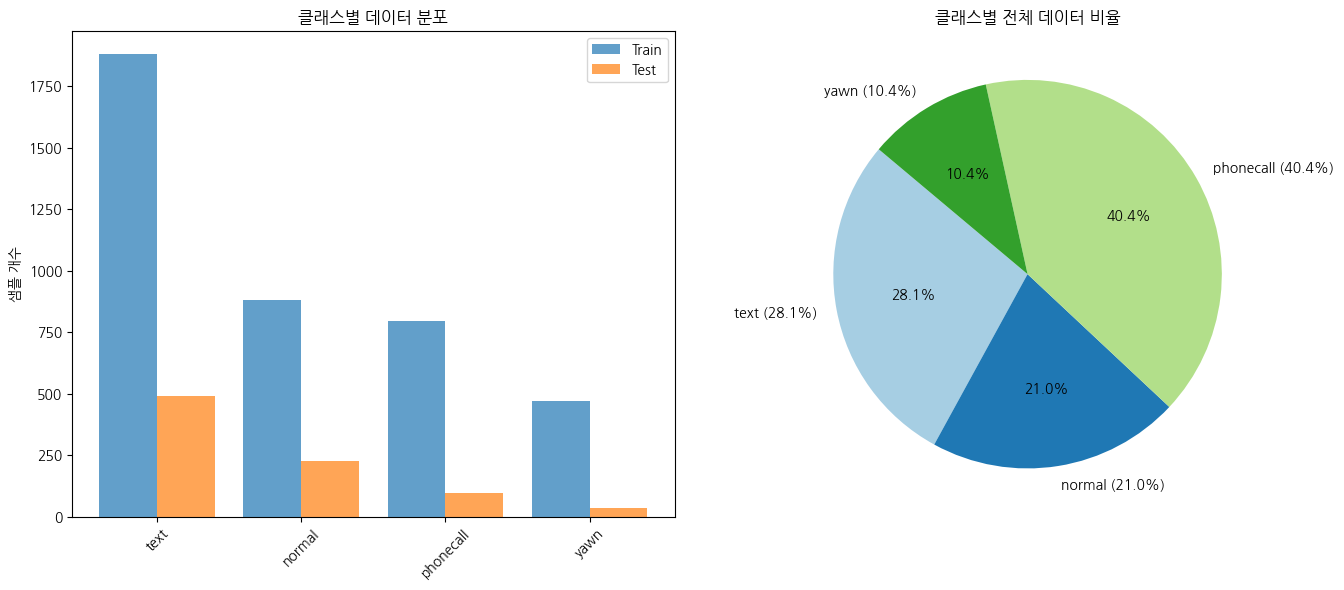

In [16]:
def visualize_data_distribution(train_labels, test_labels, label_mapping_inverse):
    """
    훈련/테스트 데이터의 레이블 분포를 시각화하는 함수.

    Args:
        train_labels (list or pd.Series): 훈련 데이터의 레이블.
        test_labels (list or pd.Series): 테스트 데이터의 레이블.
        label_mapping_inverse (dict): 정수형 레이블을 문자열로 매핑하는 딕셔너리.
    """
    # 레이블 개수 및 비율 계산
    train_label_counts = pd.Series(train_labels).value_counts()
    train_label_ratios = pd.Series(train_labels).value_counts(normalize=True) * 100

    test_label_counts = pd.Series(test_labels).value_counts()
    test_label_ratios = pd.Series(test_labels).value_counts(normalize=True) * 100

    # 클래스 이름 매핑
    class_names = [label_mapping_inverse[label] for label in train_label_counts.index]

    # 시각화
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # (왼쪽) Bar Chart - 클래스별 샘플 개수 비교
    x = np.arange(len(class_names))
    width = 0.4

    axes[0].bar(x - width / 2, train_label_counts.values, width, label="Train", alpha=0.7)
    axes[0].bar(x + width / 2, test_label_counts.values, width, label="Test", alpha=0.7)
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(class_names, rotation=45)
    axes[0].set_ylabel("샘플 개수")
    axes[0].set_title("클래스별 데이터 분포")
    axes[0].legend()

    # (오른쪽) Pie Chart - 전체 데이터 비율
    total_counts = train_label_counts + test_label_counts
    total_ratios = total_counts / total_counts.sum() * 100

    axes[1].pie(
        total_counts,
        labels=[f"{class_names[i]} ({total_ratios[i]:.1f}%)" for i in range(len(class_names))],
        autopct="%1.1f%%",
        startangle=140,
        colors=plt.cm.Paired.colors,
    )
    axes[1].set_title("클래스별 전체 데이터 비율")

    plt.tight_layout()
    plt.show()

visualize_data_distribution(train_labels, test_labels, label_mapping_inverse)

### DataLoader

In [17]:
# DataLoader 설정
params = {
    "batch_size": config["batch_size"],
    "shuffle": True,
    "num_workers": 4,
    "pin_memory": True,
    "persistent_workers": True,
    "prefetch_factor": 2,
} if config["use_cuda"] else {}

In [18]:
# DataLoader 생성 (배치 단위로 데이터를 나누기 위해 사용)
train_dataset = TensorDataset(train_features, train_labels)
validation_dataset = TensorDataset(validation_features, validation_labels)
test_dataset = TensorDataset(test_features, test_labels)

train_loader = DataLoader(train_dataset, **params)
validation_loader = DataLoader(validation_dataset, **params)
test_loader = DataLoader(test_dataset, **params)

# 배치 단위 확인
for x_batch, y_batch in train_loader:
    print("Batch Shape:", x_batch.shape, y_batch.shape)  # (batch_size, timestep, feature), (batch_size,)
    break  # 한 배치만 확인

for x_batch, y_batch in validation_loader:
    print("Batch Shape:", x_batch.shape, y_batch.shape)  # (batch_size, timestep, feature), (batch_size,)
    break  # 한 배치만 확인

for x_batch, y_batch in test_loader:
    print("Batch Shape:", x_batch.shape, y_batch.shape)  # (batch_size, timestep, feature), (batch_size,)
    break  # 한 배치만 확인

Batch Shape: torch.Size([32, 24, 5]) torch.Size([32])
Batch Shape: torch.Size([32, 24, 5]) torch.Size([32])
Batch Shape: torch.Size([32, 24, 5]) torch.Size([32])


In [19]:
# # Train, Test 라벨별 개수 확인
labels = train_labels.to(torch.long)#  Long 타입으로 변환
counts = torch.bincount(labels)
print(counts)

labels = validation_labels.to(torch.long)#  Long 타입으로 변환
counts = torch.bincount(labels)
print(counts)

labels = test_labels.to(torch.long)
counts = torch.bincount(labels)
print(counts)

tensor([ 882,  797, 1880,  472])
tensor([461, 218, 106,  28])
tensor([493, 229,  96,  38])


## 1-3. LSTM 학습

In [20]:
# LSTM 모델 정의
class DecoderRNN(nn.Module):
    def __init__(self, config):
        super(DecoderRNN, self).__init__()

        self.RNN_input_size = config['feature_num']  # 특징 개수
        self.h_RNN_layers = config["RNN_hidden_layers"]
        self.h_RNN = config["RNN_hidden_nodes"]
        self.h_FC_dim = config["RNN_FC_dim"]
        self.drop_p = config["dropout_p"]
        self.num_classes = config["k"]

        self.LSTM = nn.LSTM(
            input_size=self.RNN_input_size,
            hidden_size=self.h_RNN,
            num_layers=self.h_RNN_layers,
            batch_first=True,
        )

        self.fc1 = nn.Linear(self.h_RNN, self.h_FC_dim)
        self.fc2 = nn.Linear(self.h_FC_dim, self.num_classes)
        self.dropout = nn.Dropout(p=self.drop_p)

    def forward(self, x_RNN):
        self.LSTM.flatten_parameters()
        RNN_out, _ = self.LSTM(x_RNN, None)

        # FC layers
        x = self.fc1(RNN_out[:, -1, :])  # 마지막 타임스텝a 사용
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x  # CrossEntropyLoss 사용 (Softmax 없음)

### optimizer

In [21]:
def get_optimizer(model, config):
    return optim.Adam(model.parameters(), lr=config["learning_rate"])
criterion = nn.CrossEntropyLoss()

### 학습률 감소 스케줄러 설정
Test Loss 기준
- factor: 0.5, 학습률 50% 감소
- verbose: True, 감소된 경우 로그 출력

In [22]:
def get_scheduler(optimizer, config):
    return optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode="min",
        factor=config["reduce_lr_factor"],
        patience=config["reduce_lr_patience"],
    )

### Early Stopping 설정

In [23]:
early_stopping_patience = config["early_stopping_patience"]
best_loss = np.inf
patience_counter = 0

## 학습 진행

- Mixed Precision Training 유지 (torch.cuda.amp.autocast() + GradScaler())
-  Gradient Clipping 추가 (torch.nn.utils.clip_grad_norm_()) → 폭발적인 기울기(Gradient Explosion) 방지
- 모델 저장 기능 추가 (torch.save()) → Best Loss 갱신 시 자동 저장
- 학습률 스케줄러 로깅 추가 → ReduceLROnPlateau가 작동했는지 확인 가능

In [24]:
def save_best_model(model, optimizer, epoch, best_loss, save_path):
    """Validation Loss가 가장 낮을 때만 모델을 저장하는 함수"""
    today_date = datetime.datetime.now().strftime("%Y-%m-%d")  # 날짜 가져오기
    model_filename = f"{save_path}/best_model_{today_date}.pth"  # 저장 파일명

    # 기존 최적 모델 삭제 (이전 모델 유지 안 함)
    if os.path.exists(model_filename):
        os.remove(model_filename)

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_loss': best_loss
    }, model_filename)

    print(f"💾 Best Model Updated! Saved at {model_filename} (Loss: {best_loss:.4f})")

def save_training_results(
        epoch_train_losses,
        epoch_train_scores,
        epoch_test_losses,
        epoch_test_scores,
        save_path="./",
        ):
    """
    학습 과정의 손실(loss)과 정확도(score)를 저장하는 함수
    """
    os.makedirs(save_path, exist_ok=True)

    np.save(
        os.path.join(save_path, "LSTM_epoch_training_losses.npy"),
        np.array(epoch_train_losses),
    )
    np.save(
        os.path.join(save_path, "LSTM_epoch_tsave_path, raining_scores.npy"),
        np.array(epoch_train_scores),
    )
    np.save(
        os.path.join(save_path, "LSTM_epoch_test_loss.npy"), np.array(epoch_test_losses)
    )
    np.save(
        os.path.join(save_path, "LSTM_epoch_test_score.npy"),
        np.array(epoch_test_scores),
    )

### epoch마다 validation data로 성능평가
- 다음 기술을 적용하는 기준: Validation data Loss
    - Early Stopping
    - 학습률 감소 스케줄러
    - 모델 저장 (Best Loss 갱신 시)

In [25]:
def ensure_directory_exists(path):
    """주어진 경로의 폴더가 없으면 생성하는 함수"""
    if not os.path.exists(path):
        os.makedirs(path)
        print(f"📂 Directory created: {path}")

In [26]:
# ✅ 경로 자동 생성 (존재하지 않으면 생성)
ensure_directory_exists(os.path.dirname(config["model_save_path"]))  # 모델 저장 폴더
ensure_directory_exists(config["train_result_path"])  # 학습 결과 폴더

📂 Directory created: /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results


### train & validate

In [27]:
# Mixed Precision Training을 위한 GradScaler 설정
scaler = torch.amp.GradScaler()

# 학습 결과 저장 함수
def save_training_results(epoch, train_losses, train_scores, test_losses, test_scores, save_path):
    """학습 결과를 CSV 파일로 저장하는 함수"""
    results_df = pd.DataFrame({
        "epoch": list(range(1, epoch + 2)),
        "train_loss": train_losses,
        "train_accuracy": train_scores,
        "test_loss": test_losses,
        "test_accuracy": test_scores,
    })

    results_df.to_csv(f"{save_path}/training_results.csv", index=False)
    print(f"💾 Training results saved at {save_path}/training_results.csv")

# 학습 함수
def train(log_interval, model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    losses, scores = [], []
    total_samples = 0

    # tqdm을 사용하여 학습 진행률 표시
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['epochs']}", leave=True)

    for batch_idx, (X, y) in enumerate(progress_bar):
        X, y = X.to(device), y.to(device).long()
        total_samples += X.size(0)

        optimizer.zero_grad(set_to_none=True)

        with torch.amp.autocast(device_type='cuda'):
            output = model(X)
            loss = criterion(output, y)

        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  #  Gradient Clipping
        scaler.step(optimizer)
        scaler.update()

        losses.append(loss.item())

        # 정확도 계산
        y_pred = torch.argmax(output, dim=1)
        acc = accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())
        scores.append(acc)

    avg_loss = sum(losses) / len(losses)
    avg_acc = sum(scores) / len(scores) * 100

    print(f"✅ Train Epoch {epoch+1} Finished - Avg Loss: {avg_loss:.4f}, Avg Acc: {avg_acc:.2f}%")

    return avg_loss, avg_acc  # 학습 Loss 및 Accuracy 반환

# 검증 함수
def validate(model, device, criterion, test_loader):
    model.eval()
    losses, scores = [], []

    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device).long()

            with torch.amp.autocast(device_type='cuda'):
                output = model(X)
                loss = criterion(output, y)

            losses.append(loss.item())

            # 정확도 계산
            y_pred = torch.argmax(output, dim=1)
            acc = accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())
            scores.append(acc)

    avg_loss = sum(losses) / len(losses)
    avg_acc = sum(scores) / len(scores) * 100

    print(f"✅ Validation Finished - Avg Loss: {avg_loss:.4f}, Avg Acc: {avg_acc:.2f}%")

    return avg_loss, avg_acc  # 검증 Loss 및 Accuracy 반환

In [28]:
# 전체 학습 실행 코드
def train_and_validate(model, train_loader, valid_loader, optimizer, criterion, scheduler, config):
    best_loss = np.inf  # Best Loss 초기화
    patience_counter = 0  # Early Stopping 카운터

    epoch_train_losses, epoch_train_scores = [], []
    epoch_valid_losses, epoch_valid_scores = [], []

    for epoch in range(config["epochs"]):
        # 학습 단계
        epoch_train_loss, epoch_train_score = train(
            config["log_interval"], model, config["device"], train_loader, optimizer, criterion, epoch
        )

        # 검증 단계
        epoch_valid_loss, epoch_valid_score = validate(
            model, config["device"], criterion, valid_loader,
        )

        # 결과 저장
        epoch_train_losses.append(epoch_train_loss)
        epoch_train_scores.append(epoch_train_score)
        epoch_valid_losses.append(epoch_valid_loss)
        epoch_valid_scores.append(epoch_valid_score)

        # 학습률 감소 적용
        scheduler.step(epoch_valid_loss)

        # Early Stopping 체크
        if epoch_valid_loss < best_loss:
            best_loss = epoch_valid_loss
            patience_counter = 0  # 개선되었으므로 patience 초기화

            save_best_model(model, optimizer, epoch, best_loss, config["model_save_path"])
            print(f"💾 Model Saved! New Best Loss: {best_loss:.4f}")
        else:
            patience_counter += 1
            print(f"⏳ Early stopping 대기 카운트: {patience_counter}/{config['early_stopping_patience']}")

        # 설정된 patience 횟수만큼 개선되지 않으면 학습 중단
        if patience_counter >= config["early_stopping_patience"]:
            print("⏹️ Early stopping 적용됨. 학습 종료.")
            break  # 학습 중단

        # 학습 결과 저장
        save_training_results(
            epoch,
            epoch_train_losses,
            epoch_train_scores,
            epoch_valid_losses,
            epoch_valid_scores,
            save_path=config["train_result_path"],
        )

    return epoch_train_losses, epoch_train_scores, epoch_valid_losses, epoch_valid_scores

In [29]:
model = DecoderRNN(config)
model.to(config["device"])  # 모델을 GPU로 이동

optimizer = get_optimizer(model, config)
scheduler = get_scheduler(optimizer, config)

epoch_train_losses, epoch_train_scores, epoch_valid_losses, epoch_valid_scores = train_and_validate(model, train_loader, validation_loader, optimizer, criterion, scheduler, config)
# RuntimeError: DataLoader worker -> dataloader 재실행

Epoch 1/100: 100%|██████████| 126/126 [00:03<00:00, 32.17it/s]


✅ Train Epoch 1 Finished - Avg Loss: 1.3273, Avg Acc: 41.21%
✅ Validation Finished - Avg Loss: 1.5174, Avg Acc: 12.92%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/best_model_2025-03-18.pth (Loss: 1.5174)
💾 Model Saved! New Best Loss: 1.5174
💾 Training results saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results/training_results.csv


Epoch 2/100: 100%|██████████| 126/126 [00:01<00:00, 64.24it/s]


✅ Train Epoch 2 Finished - Avg Loss: 1.2550, Avg Acc: 46.63%
✅ Validation Finished - Avg Loss: 1.4801, Avg Acc: 12.92%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/best_model_2025-03-18.pth (Loss: 1.4801)
💾 Model Saved! New Best Loss: 1.4801
💾 Training results saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results/training_results.csv


Epoch 3/100: 100%|██████████| 126/126 [00:01<00:00, 82.86it/s]


✅ Train Epoch 3 Finished - Avg Loss: 1.1400, Avg Acc: 50.01%
✅ Validation Finished - Avg Loss: 1.2161, Avg Acc: 36.15%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/best_model_2025-03-18.pth (Loss: 1.2161)
💾 Model Saved! New Best Loss: 1.2161
💾 Training results saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results/training_results.csv


Epoch 4/100: 100%|██████████| 126/126 [00:01<00:00, 84.02it/s]


✅ Train Epoch 4 Finished - Avg Loss: 0.9603, Avg Acc: 57.90%
✅ Validation Finished - Avg Loss: 1.0936, Avg Acc: 36.28%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/best_model_2025-03-18.pth (Loss: 1.0936)
💾 Model Saved! New Best Loss: 1.0936
💾 Training results saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results/training_results.csv


Epoch 5/100: 100%|██████████| 126/126 [00:01<00:00, 84.24it/s]


✅ Train Epoch 5 Finished - Avg Loss: 0.9338, Avg Acc: 58.79%
✅ Validation Finished - Avg Loss: 1.0761, Avg Acc: 35.92%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/best_model_2025-03-18.pth (Loss: 1.0761)
💾 Model Saved! New Best Loss: 1.0761
💾 Training results saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results/training_results.csv


Epoch 6/100: 100%|██████████| 126/126 [00:01<00:00, 76.90it/s]


✅ Train Epoch 6 Finished - Avg Loss: 0.9238, Avg Acc: 59.04%
✅ Validation Finished - Avg Loss: 1.1053, Avg Acc: 35.68%
⏳ Early stopping 대기 카운트: 1/20
💾 Training results saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results/training_results.csv


Epoch 7/100: 100%|██████████| 126/126 [00:02<00:00, 57.03it/s]


✅ Train Epoch 7 Finished - Avg Loss: 0.9196, Avg Acc: 59.37%
✅ Validation Finished - Avg Loss: 1.0850, Avg Acc: 35.85%
⏳ Early stopping 대기 카운트: 2/20
💾 Training results saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results/training_results.csv


Epoch 8/100: 100%|██████████| 126/126 [00:01<00:00, 73.09it/s]


✅ Train Epoch 8 Finished - Avg Loss: 0.9145, Avg Acc: 59.54%
✅ Validation Finished - Avg Loss: 1.1054, Avg Acc: 36.52%
⏳ Early stopping 대기 카운트: 3/20
💾 Training results saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results/training_results.csv


Epoch 9/100: 100%|██████████| 126/126 [00:01<00:00, 82.55it/s]


✅ Train Epoch 9 Finished - Avg Loss: 0.9112, Avg Acc: 59.41%
✅ Validation Finished - Avg Loss: 1.0418, Avg Acc: 38.02%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/best_model_2025-03-18.pth (Loss: 1.0418)
💾 Model Saved! New Best Loss: 1.0418
💾 Training results saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results/training_results.csv


Epoch 10/100: 100%|██████████| 126/126 [00:01<00:00, 82.22it/s]


✅ Train Epoch 10 Finished - Avg Loss: 0.9056, Avg Acc: 60.26%
✅ Validation Finished - Avg Loss: 1.0713, Avg Acc: 38.39%
⏳ Early stopping 대기 카운트: 1/20
💾 Training results saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results/training_results.csv


Epoch 11/100: 100%|██████████| 126/126 [00:01<00:00, 84.24it/s]


✅ Train Epoch 11 Finished - Avg Loss: 0.8990, Avg Acc: 60.63%
✅ Validation Finished - Avg Loss: 1.0488, Avg Acc: 40.83%
⏳ Early stopping 대기 카운트: 2/20
💾 Training results saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results/training_results.csv


Epoch 12/100: 100%|██████████| 126/126 [00:01<00:00, 82.13it/s]


✅ Train Epoch 12 Finished - Avg Loss: 0.8942, Avg Acc: 61.62%
✅ Validation Finished - Avg Loss: 1.0415, Avg Acc: 41.68%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/best_model_2025-03-18.pth (Loss: 1.0415)
💾 Model Saved! New Best Loss: 1.0415
💾 Training results saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results/training_results.csv


Epoch 13/100: 100%|██████████| 126/126 [00:01<00:00, 84.46it/s]


✅ Train Epoch 13 Finished - Avg Loss: 0.8803, Avg Acc: 62.62%
✅ Validation Finished - Avg Loss: 1.0806, Avg Acc: 44.39%
⏳ Early stopping 대기 카운트: 1/20
💾 Training results saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results/training_results.csv


Epoch 14/100: 100%|██████████| 126/126 [00:02<00:00, 56.65it/s]


✅ Train Epoch 14 Finished - Avg Loss: 0.8695, Avg Acc: 62.82%
✅ Validation Finished - Avg Loss: 0.9878, Avg Acc: 49.20%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/best_model_2025-03-18.pth (Loss: 0.9878)
💾 Model Saved! New Best Loss: 0.9878
💾 Training results saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results/training_results.csv


Epoch 15/100: 100%|██████████| 126/126 [00:01<00:00, 66.30it/s]


✅ Train Epoch 15 Finished - Avg Loss: 0.8617, Avg Acc: 63.08%
✅ Validation Finished - Avg Loss: 0.9658, Avg Acc: 50.99%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/best_model_2025-03-18.pth (Loss: 0.9658)
💾 Model Saved! New Best Loss: 0.9658
💾 Training results saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results/training_results.csv


Epoch 16/100: 100%|██████████| 126/126 [00:01<00:00, 76.32it/s]


✅ Train Epoch 16 Finished - Avg Loss: 0.8555, Avg Acc: 63.46%
✅ Validation Finished - Avg Loss: 1.0139, Avg Acc: 45.89%
⏳ Early stopping 대기 카운트: 1/20
💾 Training results saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results/training_results.csv


Epoch 17/100: 100%|██████████| 126/126 [00:01<00:00, 79.33it/s]


✅ Train Epoch 17 Finished - Avg Loss: 0.8466, Avg Acc: 63.91%
✅ Validation Finished - Avg Loss: 0.9981, Avg Acc: 46.85%
⏳ Early stopping 대기 카운트: 2/20
💾 Training results saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results/training_results.csv


Epoch 18/100: 100%|██████████| 126/126 [00:01<00:00, 82.80it/s]


✅ Train Epoch 18 Finished - Avg Loss: 0.8405, Avg Acc: 64.30%
✅ Validation Finished - Avg Loss: 1.0222, Avg Acc: 45.22%
⏳ Early stopping 대기 카운트: 3/20
💾 Training results saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results/training_results.csv


Epoch 19/100: 100%|██████████| 126/126 [00:01<00:00, 82.47it/s]


✅ Train Epoch 19 Finished - Avg Loss: 0.8302, Avg Acc: 65.47%
✅ Validation Finished - Avg Loss: 1.0147, Avg Acc: 47.92%
⏳ Early stopping 대기 카운트: 4/20
💾 Training results saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results/training_results.csv


Epoch 20/100: 100%|██████████| 126/126 [00:01<00:00, 82.92it/s]


✅ Train Epoch 20 Finished - Avg Loss: 0.8113, Avg Acc: 65.42%
✅ Validation Finished - Avg Loss: 0.9987, Avg Acc: 47.93%
⏳ Early stopping 대기 카운트: 5/20
💾 Training results saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results/training_results.csv


Epoch 21/100: 100%|██████████| 126/126 [00:02<00:00, 55.40it/s]


✅ Train Epoch 21 Finished - Avg Loss: 0.8017, Avg Acc: 66.34%
✅ Validation Finished - Avg Loss: 1.0019, Avg Acc: 46.14%
⏳ Early stopping 대기 카운트: 6/20
💾 Training results saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results/training_results.csv


Epoch 22/100: 100%|██████████| 126/126 [00:02<00:00, 55.99it/s]


✅ Train Epoch 22 Finished - Avg Loss: 0.7951, Avg Acc: 66.18%
✅ Validation Finished - Avg Loss: 0.9936, Avg Acc: 46.73%
⏳ Early stopping 대기 카운트: 7/20
💾 Training results saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results/training_results.csv


Epoch 23/100: 100%|██████████| 126/126 [00:01<00:00, 73.77it/s]


✅ Train Epoch 23 Finished - Avg Loss: 0.7921, Avg Acc: 66.38%
✅ Validation Finished - Avg Loss: 1.0054, Avg Acc: 46.09%
⏳ Early stopping 대기 카운트: 8/20
💾 Training results saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results/training_results.csv


Epoch 24/100: 100%|██████████| 126/126 [00:01<00:00, 76.61it/s]


✅ Train Epoch 24 Finished - Avg Loss: 0.7868, Avg Acc: 67.00%
✅ Validation Finished - Avg Loss: 0.9943, Avg Acc: 47.26%
⏳ Early stopping 대기 카운트: 9/20
💾 Training results saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results/training_results.csv


Epoch 25/100: 100%|██████████| 126/126 [00:01<00:00, 80.15it/s]


✅ Train Epoch 25 Finished - Avg Loss: 0.7862, Avg Acc: 67.01%
✅ Validation Finished - Avg Loss: 0.9964, Avg Acc: 46.67%
⏳ Early stopping 대기 카운트: 10/20
💾 Training results saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results/training_results.csv


Epoch 26/100: 100%|██████████| 126/126 [00:01<00:00, 77.12it/s]


✅ Train Epoch 26 Finished - Avg Loss: 0.7866, Avg Acc: 66.93%
✅ Validation Finished - Avg Loss: 0.9949, Avg Acc: 47.14%
⏳ Early stopping 대기 카운트: 11/20
💾 Training results saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results/training_results.csv


Epoch 27/100: 100%|██████████| 126/126 [00:01<00:00, 80.88it/s]


✅ Train Epoch 27 Finished - Avg Loss: 0.7815, Avg Acc: 67.35%
✅ Validation Finished - Avg Loss: 1.0011, Avg Acc: 46.50%
⏳ Early stopping 대기 카운트: 12/20
💾 Training results saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results/training_results.csv


Epoch 28/100: 100%|██████████| 126/126 [00:02<00:00, 60.33it/s]


✅ Train Epoch 28 Finished - Avg Loss: 0.7821, Avg Acc: 67.10%
✅ Validation Finished - Avg Loss: 0.9901, Avg Acc: 46.97%
⏳ Early stopping 대기 카운트: 13/20
💾 Training results saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results/training_results.csv


Epoch 29/100: 100%|██████████| 126/126 [00:02<00:00, 58.28it/s]


✅ Train Epoch 29 Finished - Avg Loss: 0.7840, Avg Acc: 67.33%
✅ Validation Finished - Avg Loss: 0.9947, Avg Acc: 46.62%
⏳ Early stopping 대기 카운트: 14/20
💾 Training results saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results/training_results.csv


Epoch 30/100: 100%|██████████| 126/126 [00:01<00:00, 81.53it/s]


✅ Train Epoch 30 Finished - Avg Loss: 0.7822, Avg Acc: 67.36%
✅ Validation Finished - Avg Loss: 0.9993, Avg Acc: 46.44%
⏳ Early stopping 대기 카운트: 15/20
💾 Training results saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results/training_results.csv


Epoch 31/100: 100%|██████████| 126/126 [00:01<00:00, 70.10it/s]


✅ Train Epoch 31 Finished - Avg Loss: 0.7814, Avg Acc: 67.15%
✅ Validation Finished - Avg Loss: 0.9914, Avg Acc: 47.49%
⏳ Early stopping 대기 카운트: 16/20
💾 Training results saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results/training_results.csv


Epoch 32/100: 100%|██████████| 126/126 [00:01<00:00, 75.64it/s]


✅ Train Epoch 32 Finished - Avg Loss: 0.7817, Avg Acc: 67.08%
✅ Validation Finished - Avg Loss: 0.9914, Avg Acc: 47.32%
⏳ Early stopping 대기 카운트: 17/20
💾 Training results saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results/training_results.csv


Epoch 33/100: 100%|██████████| 126/126 [00:01<00:00, 82.66it/s]


✅ Train Epoch 33 Finished - Avg Loss: 0.7838, Avg Acc: 67.45%
✅ Validation Finished - Avg Loss: 0.9892, Avg Acc: 47.14%
⏳ Early stopping 대기 카운트: 18/20
💾 Training results saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results/training_results.csv


Epoch 34/100: 100%|██████████| 126/126 [00:01<00:00, 82.14it/s]


✅ Train Epoch 34 Finished - Avg Loss: 0.7836, Avg Acc: 66.98%
✅ Validation Finished - Avg Loss: 0.9970, Avg Acc: 47.14%
⏳ Early stopping 대기 카운트: 19/20
💾 Training results saved at /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results/training_results.csv


Epoch 35/100: 100%|██████████| 126/126 [00:02<00:00, 62.48it/s]


✅ Train Epoch 35 Finished - Avg Loss: 0.7819, Avg Acc: 67.30%
✅ Validation Finished - Avg Loss: 0.9879, Avg Acc: 46.97%
⏳ Early stopping 대기 카운트: 20/20
⏹️ Early stopping 적용됨. 학습 종료.


## 결과 시각화

### 마지막 학습률 확인

In [30]:
def get_current_lr(optimizer):
    return [param_group["lr"] for param_group in optimizer.param_groups]

current_lr = get_current_lr(optimizer)
print(f"🚀 현재 Learning Rate: {current_lr}")

🚀 현재 Learning Rate: [1.0000000000000004e-08]


In [31]:
scheduler.get_last_lr()

[1.0000000000000004e-08]

### loss, accuracy 시각화

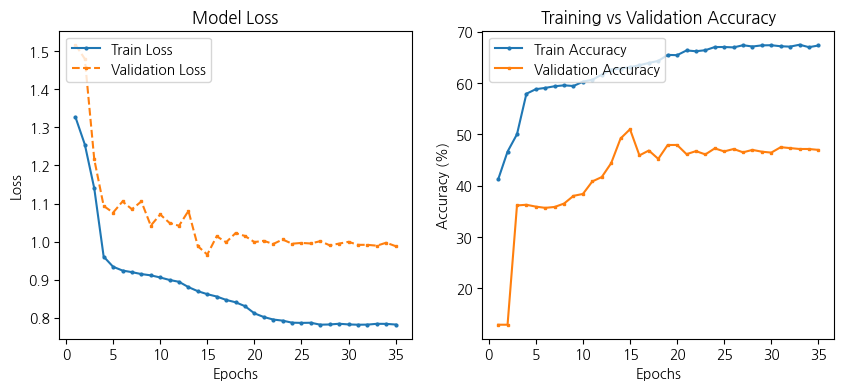


✅ 학습 및 검증 그래프 저장 완료 (/content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results/training_results.png)



In [32]:
def plot_train_test_results(
    epoch_train_losses,
    epoch_train_scores,
    epoch_test_losses,
    epoch_test_scores,
    save_path="./"
    ):
    """
    학습 및 검증 과정의 Loss 및 Accuracy를 시각화하는 함수 (Train + Test).
    """
    os.makedirs(save_path, exist_ok=True)

    A = np.array(epoch_train_losses)
    B = np.array(epoch_train_scores)
    C = np.array(epoch_test_losses)
    D = np.array(epoch_test_scores)

    fig = plt.figure(figsize=(10, 4))

    # Loss 그래프
    plt.subplot(121)
    plt.plot(np.arange(1, len(A) + 1), A, marker="o", markersize=2, linestyle="-", label="Train Loss")
    plt.plot(np.arange(1, len(C) + 1), C, marker="s", markersize=2, linestyle="--", label="Validation Loss")
    plt.title("Model Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(loc="upper left")
    # plt.ylim((0, max(2, max(A), max(C))))

    # Accuracy 그래프
    plt.subplot(122)
    plt.plot(np.arange(1, len(B) + 1), B, marker="o", markersize=2, linestyle="-", label="Train Accuracy")
    plt.plot(np.arange(1, len(D) + 1), D, marker="s", markersize=2, linestyle="-", label="Validation Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend(loc="upper left")
    # plt.ylim((0, 100))

    # 그래프 저장
    plot_save_path = os.path.join(save_path, "training_results.png")
    plt.savefig(plot_save_path, dpi=600)
    plt.show()

    print(f"\n✅ 학습 및 검증 그래프 저장 완료 ({plot_save_path})\n")

plot_train_test_results(
    epoch_train_losses,
    epoch_train_scores,
    epoch_valid_losses,
    epoch_valid_scores,
    save_path=config["train_result_path"],
)

### confusion matrix 시각화

In [33]:
# 모델 로드 함수
def load_model(model, model_save_path, device):
    """저장된 모델을 불러오는 함수"""
    checkpoint = torch.load(model_save_path, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.to(device)
    model.eval()
    print(f"✅ Model Loaded from {model_save_path}")
    return model

# Confusion Matrix 시각화 함수
def plot_confusion_matrix(y_true, y_pred, class_names, save_dir, file_name):
    """
    Confusion Matrix를 그리는 함수
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")

    # 저장 기능 추가
    if save_dir and file_name:
        os.makedirs(save_dir, exist_ok=True)  # 디렉토리가 없으면 생성
        save_path = os.path.join(save_dir, f"{file_name}_cm.png")
        plt.savefig(save_path, bbox_inches='tight')  # 이미지 저장
        print(f"✅ Confusion Matrix saved at: {save_path}")

    plt.show()

    print("\n🔹 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

# 학습 데이터에서 Confusion Matrix 계산
def evaluate_model(model, data_loader, class_names, save_dir=None, file_name=None):
    """
    모델을 평가하고 Confusion Matrix를 출력하는 함수
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            x_batch, y_batch = x_batch.to("cuda"), y_batch.to("cuda")

            y_pred = model(x_batch)  # (batch_size, num_classes)
            y_pred_classes = torch.argmax(y_pred, dim=1)  # 가장 높은 확률을 가진 클래스를 예측값으로 선택

            all_preds.extend(y_pred_classes.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    # Confusion Matrix 출력
    plot_confusion_matrix(all_labels, all_preds, class_names, save_dir, file_name)

✅ Model Loaded from /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/best_model_2025-03-18.pth
✅ Confusion Matrix saved at: /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results/train_cm.png


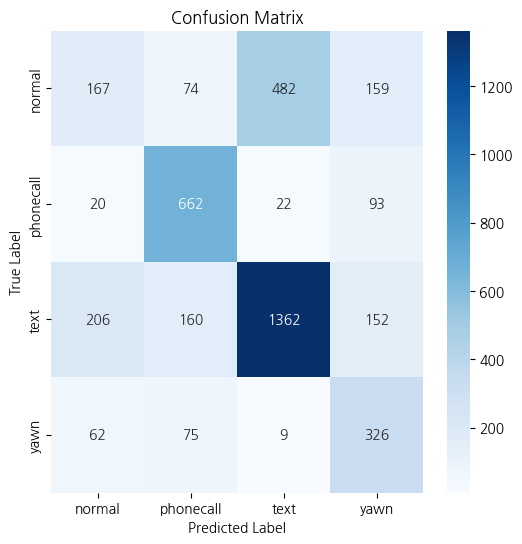


🔹 Classification Report:
              precision    recall  f1-score   support

      normal       0.37      0.19      0.25       882
   phonecall       0.68      0.83      0.75       797
        text       0.73      0.72      0.73      1880
        yawn       0.45      0.69      0.54       472

    accuracy                           0.62      4031
   macro avg       0.56      0.61      0.57      4031
weighted avg       0.61      0.62      0.60      4031



In [37]:
model = load_model(model,"/content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/best_model_2025-03-18.pth", config["device"])
class_names = config['action_names']
evaluate_model(model, train_loader, class_names, save_dir=config["train_result_path"], file_name="train")

✅ Confusion Matrix saved at: /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results/test_cm.png


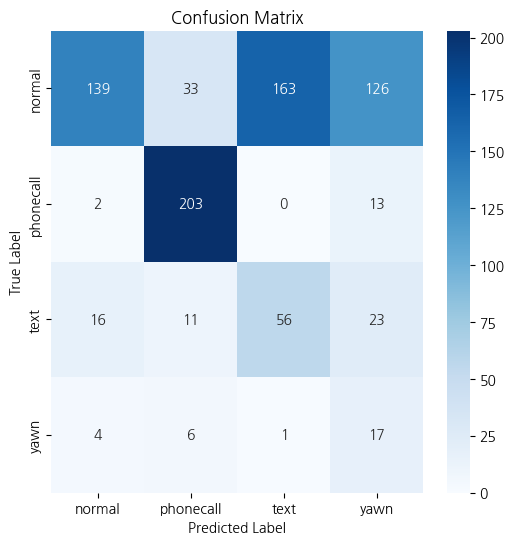


🔹 Classification Report:
              precision    recall  f1-score   support

      normal       0.86      0.30      0.45       461
   phonecall       0.80      0.93      0.86       218
        text       0.25      0.53      0.34       106
        yawn       0.09      0.61      0.16        28

    accuracy                           0.51       813
   macro avg       0.50      0.59      0.45       813
weighted avg       0.74      0.51      0.54       813



In [38]:
evaluate_model(model, validation_loader, class_names, config["train_result_path"], "test")

✅ Confusion Matrix saved at: /content/drive/MyDrive/DMS/data/model_results/031811_4s_oversample_case2_small_lr/train_results/test_cm.png


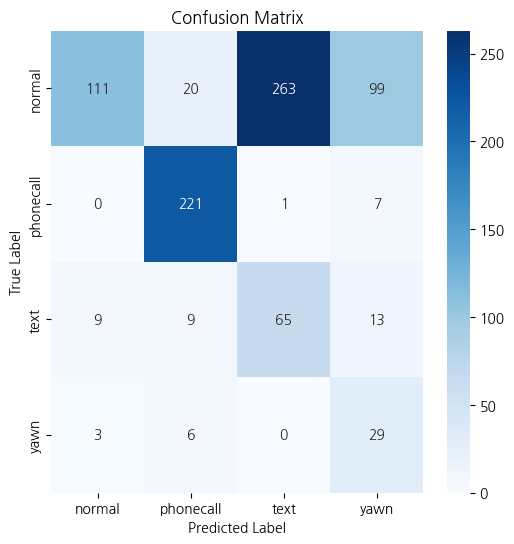


🔹 Classification Report:
              precision    recall  f1-score   support

      normal       0.90      0.23      0.36       493
   phonecall       0.86      0.97      0.91       229
        text       0.20      0.68      0.31        96
        yawn       0.20      0.76      0.31        38

    accuracy                           0.50       856
   macro avg       0.54      0.66      0.47       856
weighted avg       0.78      0.50      0.50       856



In [39]:
evaluate_model(model, test_loader, class_names, config["train_result_path"], "test")